In [1]:
# License: BSD (3-clause)

import numpy as np
import os.path as op
import matplotlib.pyplot as plt
from langouEEG import *

import mne
import pickle
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.minimum_norm import write_inverse_operator
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
dataRoot = "/data/home/viscent/Light"

In [12]:
epochs = []
for subject_name in range(1,21):
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    raw.set_channel_types({'Trigger':'stim','VEO':'eog'})
    raw.set_eeg_reference(projection=True)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')
    epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs.append(mne.concatenate_epochs([epoch_4F,epoch_RF]))
epochs=mne.concatenate_epochs(epochs)

r)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG, 1 EOG, 1 STIM
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: Average EEG reference: off
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>
channel names:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'Trigger']
time period:
1131650
events:
Used Annotations descriptions: ['11', '12', '8', '9']
{'random_flicker-60s': 1, 'random_rest-300s': 2, '40Hz_rest-300s': 3, '40Hz_flicker-60s': 4}
Not setting metadata
Not setting metadata
5 matching events 

In [13]:
tmin = 10.
tmax = 20.
fmin = 1.
fmax = 120.
sfreq = epoch_4F.info['sfreq']

# psds, freqs = mne.time_frequency.psd_welch(
#     mne.concatenate_epochs([epoch_RF,epoch_RF]),
#     n_fft=int(sfreq * (tmax - tmin)),
#     n_overlap=0, n_per_seg=None,
#     tmin=tmin, tmax=tmax,
#     fmin=fmin, fmax=fmax,
#     window='boxcar',
#     verbose=False)
psds, freqs = mne.time_frequency.psd_welch(
    epochs,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

In [14]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

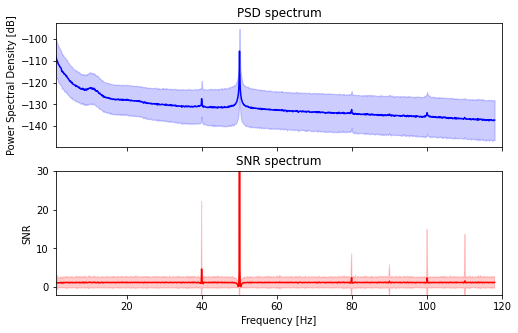

In [39]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()
fig.savefig(op.join(dataRoot,'result','spectrum.svg'))
fig.savefig(op.join(dataRoot,'result','spectrum.png'))

In [16]:
# define stimulation frequency
stim_freq = 40.
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
i_bin_40hz = np.argmin(abs(freqs - 40))
i_bin_80hz = np.argmin(abs(freqs - 80))

In [17]:
i_trial_40 = np.where(epochs.events[:, 2] == 4)[0]
i_trial_rand = np.where(epochs.events[:, 2] == 1)[0]

In [18]:
roi_vis = ['POZ', 'OZ', 'O1', 'O2', 'PO3', 'PO4', 'PO7',
           'PO8']
picks_roi_vis = mne.pick_types(epoch_4F.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

In [19]:
snrs_target = snrs[i_trial_40, :, i_bin_40hz][:, picks_roi_vis]
print("40 Hz trials, SNR at 40 Hz")
print(f'average SNR (occipital ROI): {snrs_target.mean()}')

40 Hz trials, SNR at 40 Hz
average SNR (occipital ROI): 2.6737738655855017


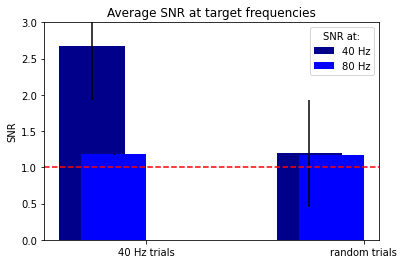

In [20]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [40, 80]
color_plot = [
    'darkblue',  'blue'
]
xpos_plot = [-5. / 12, -3. / 12, -1. / 12, 1. / 12, 3. / 12, 5. / 12]
fig, ax = plt.subplots()
labels = ['40 Hz trials', 'random trials']
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_12hz_tmp = \
        snrs_roi[i_trial_40, np.argmin(abs(freqs - f))]
    stim_15hz_tmp = \
        snrs_roi[i_trial_rand, np.argmin(abs(freqs - f))]
    SNR_tmp = [stim_12hz_tmp.mean(), stim_15hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i], SNR_tmp, width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label='%i Hz SNR' % f, color=color_plot[i])
    # store results for statistical comparison
    res['stim_40hz_snrs_%ihz' % f] = stim_12hz_tmp
    res['stim_random_snrs_%ihz' % f] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SNR')
ax.set_title('Average SNR at target frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['%i Hz' % f for f in freq_plot], title='SNR at:')
ax.set_ylim([0, 3])
ax.axhline(1, ls='--', c='r')
fig.show()

In [34]:
res_pd=pd.DataFrame(dict([(k, pd.Series(v)) for k, v in res.items()]))


In [35]:
res_pd

,stim_40hz_snrs_40hz,stim_random_snrs_40hz,stim_40hz_snrs_80hz,stim_random_snrs_80hz
0,1.171114,0.169800,0.629780,0.339247
1,9.493705,0.513178,0.961408,0.359536
2,0.553345,0.756724,1.428183,0.751172
3,1.947936,0.588180,0.512276,1.672595
4,0.539117,2.843778,1.002320,2.471215
...,...,...,...,...
98,1.579004,NaN,0.340315,NaN
99,0.568889,NaN,0.740768,NaN
100,1.838332,NaN,0.352563,NaN
101,2.343699,NaN,1.375173,NaN


In [37]:
res_pd.to_excel(op.join(dataRoot,'result','SNR_data.xlsx'), index=False)